In [5]:
import cv2 as cv
from matplotlib import pyplot as plt
import numpy as np

In [2]:
def imshow(image):
    cv.imshow('image', image)
    cv.waitKey(0) 
    cv.destroyWindow('image')

Все преобразования изображения сводятся к умножению на соотвествующую матрицу. Соответственно операции отличаются
этой матрицей и её размерностью. Второй пункт не совсем верный. Простейшие операции выполняются матрицей 2х2, более сложные 3х3.
Однако мы вполне можем перейти от одной к другой. Например:
вращение :  
[x,y] = [  
    [cos(o) , -sin(o)],  
    [sin(o) , cos(o)]  
] * [x',y']   

но от нее мы можем перейти к матрице 
[x,y,z] = [  
    [cos(o) , -sin(o) ,  0 ],  
    [sin(o) , cos(o) , 0 ]  
    [0 , 0 , 1]  
] * [x',y',z']  

и результат останется тем же 

пример базовых аффиных преобразований:

![trasform1](./info/Tranformations1.png)

In [4]:
img = cv.imread('./ph/largeCat.jpg')
img = cv.resize(img , (640,640), interpolation=cv.INTER_AREA)

#### Translations

это сдвиг по оси х или y 

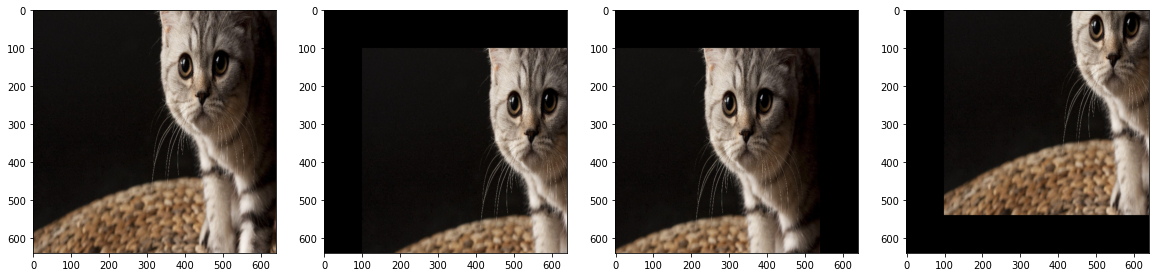

In [11]:
def translate(im, x ,y):
    transMatrix = np.float32([[1,0,x],[0,1,y]])
    return cv.warpAffine(im, transMatrix, (im.shape[1], im.shape[0]))


f = plt.figure(figsize=(20,20))
f.add_subplot(141)
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
f.add_subplot(142)
plt.imshow(cv.cvtColor(translate(img,100,100), cv.COLOR_BGR2RGB))
f.add_subplot(143)
plt.imshow(cv.cvtColor(translate(img,-100,100), cv.COLOR_BGR2RGB))
f.add_subplot(144)
plt.imshow(cv.cvtColor(translate(img,100,-100), cv.COLOR_BGR2RGB))

#### Rotation

Ну, это просто вращение. Кажется, все просто 

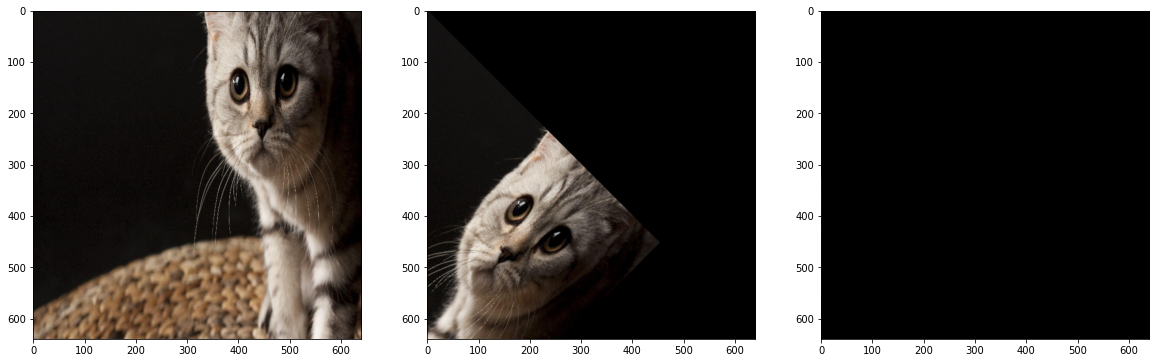

In [21]:
def rotate1(im, angle):
    (h,w) = im.shape[:2]
    rotationMatrix = np.float32( [[np.cos(angle), -1*np.sin(angle),0] ,[np.sin(angle), np.cos(angle), 0]])
    return cv.warpAffine(img, rotationMatrix, (w,h))

f = plt.figure(figsize=(20,20))
f.add_subplot(131)
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
f.add_subplot(132)
plt.imshow(cv.cvtColor(rotate1(img,np.pi/4), cv.COLOR_BGR2RGB))
f.add_subplot(133)
plt.imshow(cv.cvtColor(rotate1(img,np.pi/2), cv.COLOR_BGR2RGB))


Это верный подход, но не до конца. Мы вращаем относительно точки начала координат. Поэтому если повернуть на 90 градусов, картинка оказывается вне нашего поля зрения  
поэтому нужно дополнительно воспользоваться операцией Translation и сдвинуть точку начала координат. Логика такая: мы сдвигаем картинку так, чтобы точка, вокруг которой вращаем  
располагалась в 0,0. Для этого двигаем на (-x,-y), затем вращаем и после возвращаем картинку на исходную позицию, то есть двигаем на (x,y)

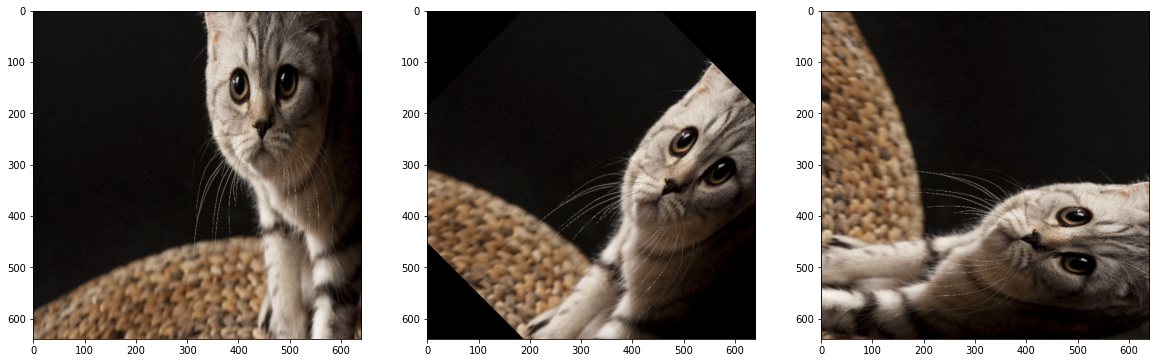

In [31]:
def getTranslationMatrix(x,y):
    return np.float32([[1,0,x],[0,1,y],[0,0,1]])

def rotate2(im, angle):
    (h,w) = im.shape[:2]
    centerX = w//2
    centerY = h//2
    rotationMatrix = np.float32( [[np.cos(angle), -1*np.sin(angle),0] ,[np.sin(angle), np.cos(angle), 0], [0, 0, 1]] )
    finalMatrix = np.matmul(getTranslationMatrix(centerX,centerY), np.matmul(rotationMatrix, getTranslationMatrix(-1*centerX, -1 * centerY)) )
    return cv.warpAffine(im, finalMatrix[:2], (w,h))

f = plt.figure(figsize=(20,20))
f.add_subplot(131)
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
f.add_subplot(132)
plt.imshow(cv.cvtColor(rotate2(img,np.pi/4), cv.COLOR_BGR2RGB))
f.add_subplot(133)
plt.imshow(cv.cvtColor(rotate2(img,np.pi/2), cv.COLOR_BGR2RGB))


А можно не морочить голову и просто позвать cv функцию, которая расчитает все за нас

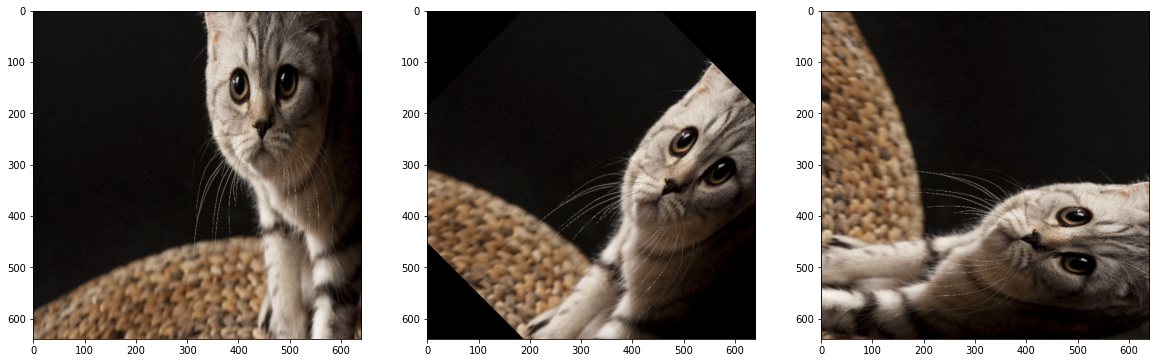

In [32]:
def rotate3(im, angle):
    (h,w) = im.shape[:2]
    centerX = w//2
    centerY = h//2
    rotationMatrix = cv.getRotationMatrix2D((centerX,centerY), angle)
    return cv.warpAffine(im, rotationMatrix[:2], (w,h))

f = plt.figure(figsize=(20,20))
f.add_subplot(131)
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
f.add_subplot(132)
plt.imshow(cv.cvtColor(rotate2(img,np.pi/4), cv.COLOR_BGR2RGB))
f.add_subplot(133)
plt.imshow(cv.cvtColor(rotate2(img,np.pi/2), cv.COLOR_BGR2RGB))

#### Scaling

Это стандартный rescale картинки, к которому мы привыкли, ничего сложного

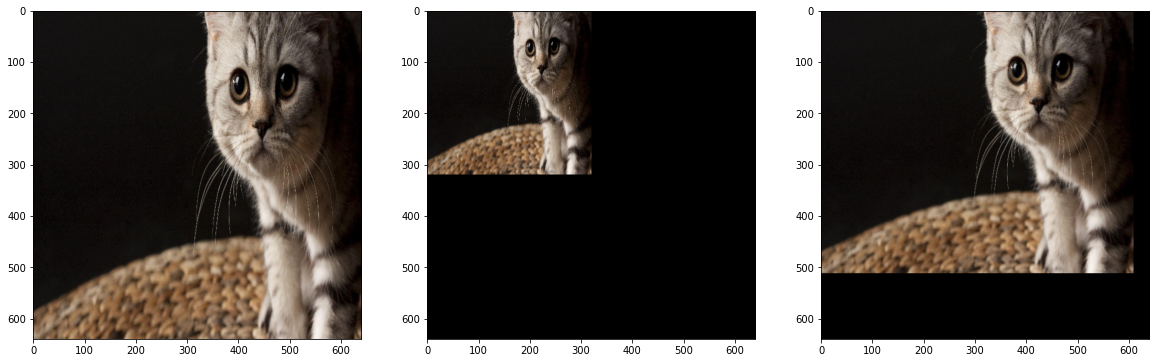

In [37]:
def scale(im ,sx,sy):
    (h,w) = im.shape[:2]
    scalingMatrix = np.float32([[sx,0,0],[0,sy,0]])
    return cv.warpAffine(im , scalingMatrix, (w,h))
f = plt.figure(figsize=(20,20))
f.add_subplot(131)
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
f.add_subplot(132)
plt.imshow(cv.cvtColor(scale(img,0.5,0.5), cv.COLOR_BGR2RGB))
f.add_subplot(133)
plt.imshow(cv.cvtColor(scale(img,0.95,0.8), cv.COLOR_BGR2RGB))

#### Skew 

Это превращение нашей прямоугольной картинки в трапецию/параллелограмм, чтобы корректно отобразить её, нужно использовать ранее озвученный scale и translate

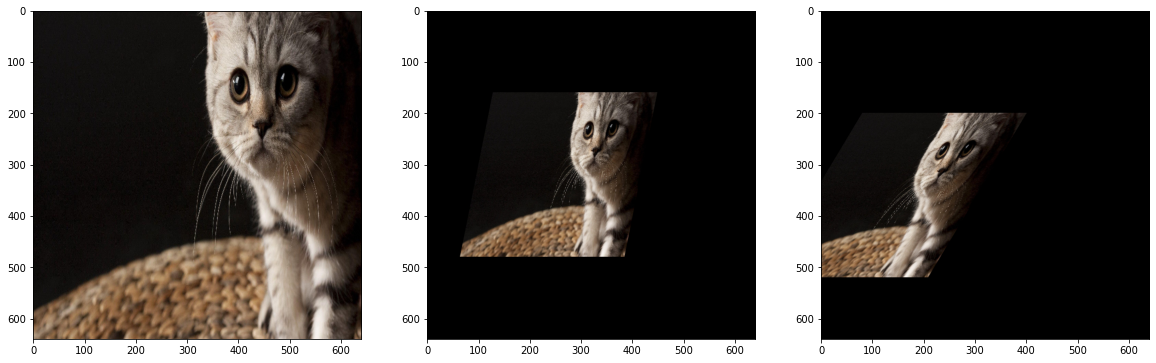

In [57]:
def skew(im ,mx):
    (h,w) = im.shape[:2]
    skewingMatrix = np.float32([[1,mx,0],[0, 1,0]])
    return cv.warpAffine(im , skewingMatrix, (w,h))
f = plt.figure(figsize=(20,20))
f.add_subplot(131)
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
f.add_subplot(132)
plt.imshow(cv.cvtColor(skew(translate(scale(img, 0.5,0.5), 160,160),-0.2), cv.COLOR_BGR2RGB))
f.add_subplot(133)
plt.imshow(cv.cvtColor(skew(translate(scale(img, 0.5,0.5), 200,200),-0.6), cv.COLOR_BGR2RGB))